<b><h1>Facial Emotion Recogniton with CNN

In [1]:
# importing all the neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import Callback, EarlyStopping

import scikitplot
import seaborn as sns
from sklearn.model_selection  import train_test_split
from sklearn.metrics import classification_report, accuracy_score

Init Plugin
Init Graph Optimizer
Init Kernel


<b>1. Data preparation  (datasets both for training and testing are taken from kaggle.com)

In [3]:
data = pd.read_csv('./fer2013.csv') # reading a cv file 
data.head(5) # prining first 5 entries

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


If you pay enough attention to the data set You'll notice that:
- the first column contains the  id of an image
- the second column specifies the class of an image ( 0 1 2 3 5 6 - each number stands for a different emotion)
- the fird column is an 1D array of pixes - digital representaion of an image ) 
- and the last column is used to specify the usage of an entry - if it's used for training or testing 

In [4]:
img_width, img_height = 48, 48 # our images are the dimension of 48 * 48 pixels 

# getting only the second column with raw pixels and converting it to list
pixel_rows = data['pixels'].tolist()

# converting each value of every row to int and reshaping to 48 * 48 dimension 
X = []
for pixel_row in pixel_rows:
    px_r = []
    for p in pixel_row.split(' '):
        px_r.append(int(p))
    px_r = np.asarray(px_r).reshape(img_width, img_height)
    X.append(px_r.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

# getting labels of the images
Y = pd.get_dummies(data['emotion']).to_numpy()

print("Total num of entries: {}".format( str(len(X))))
print("Num of features: {}".format( str(len(X[0]))))
print("Num of classes: {}".format( str(len(Y[0]))))

Total num of entries: 35887
Num of features: 48
Num of classes: 7


Next step is to normalize our training set
Normalization of the input allows the gradient descent to converge faster and lead to  a better performance of the final model

In [6]:
# Normalazing the data set
X -= np.mean(X, axis=0) # subtracting the mean
X /= np.std(X, axis=0) # normalizing the variance 

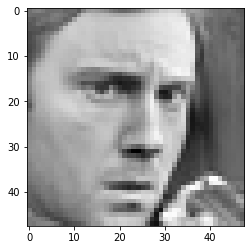

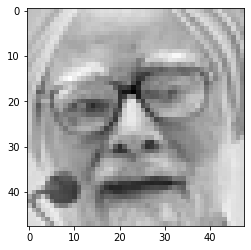

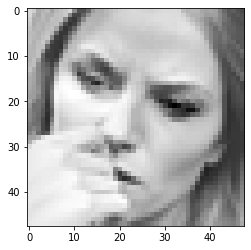

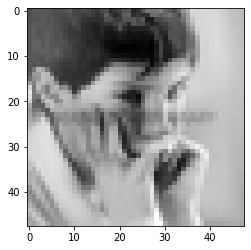

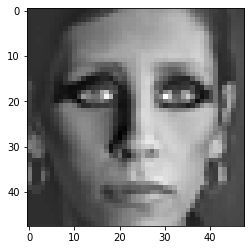

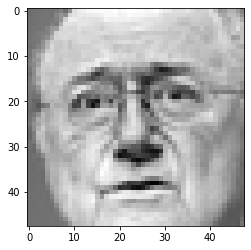

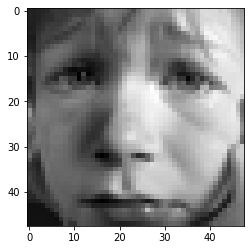

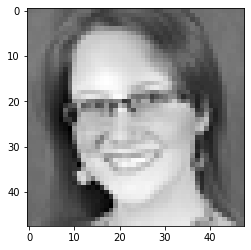

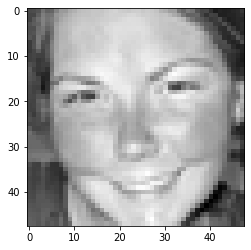

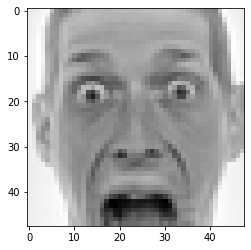

In [8]:
# Plotting 5 examples of the data set
for i in range(10):
    plt.figure(i)
    plt.imshow(X[i].reshape((48, 48)), interpolation='none', cmap='gray')
plt.show()

Next step is to split our training data set into  Traning Dev(Validation) and Test sets

Usually we do that if we only got a traning set
    
A couple things should be pointed out:
    
    - if your data set is too large ( like 5 mln+ examaples) then split it the following proportion: 98 1 1. Otherwise, you shoud stick to the following proportion: 60 20 20 or 70 30
    
    - make sure that your data set comes from the same destribution ( for instances, images have to have the same resoluto and etc) 
    
        

In [10]:
# Splitting the data set into train validation and test sets

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y,
                                       test_size=0.1,
                                       shuffle=True, random_state=41)

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train,
                                       test_size=0.1,
                                       shuffle=True, random_state=41)

print(X_train.shape, X_valid.shape, X_test.shape)

(29068, 48, 48, 1) (3589, 48, 48, 1) (3230, 48, 48, 1)


<b>2. Now is high time to build an architecture of our Convolutioal NN

Our CNN will have:

* 6 convolutional 2D layers  - you never know how many layers you need ! 2D - since we used 2 dimensional image as an input
* 1 fully connected Dense layers with 64 outputs
* one Flatten layer - gets 64 feature maps with dim 3x3 and outputs a vector of   1 x 3 * 3 * 64
* output layer with  7 perceptrones(outputs) with an SoftMax activational function (bc of multiclassification) 
* optimizer - adam
* loss function - categorical_crossentropy

Additional traits of the CNN achitecture: 

* core size (filter)  3 * 3
* activational  function on each layer  - relu
* pooling ( MaxPooling) 2 x 2

For better performance of Cnn were added: 
* batch normalization layer on every layer 

* 1 Dropout layer  with keep_prob of  0.8 ( 0.2 - probability of dropping out a  random node) 

* сallback for early stopping - to prevent overfitting 
* Mini-Batch Gradient Descent with the size of 128 examples  - helps our model to generalize better and serves as a 
regularization techniq. Also expedites the learning process and makes progress without need to wait ( since we use less batch size for training)
* L2 (Ridge) regularization

In [15]:
def build_model():
    model = Sequential()
    
    model.add(
        Conv2D(
            filters = 256,
            kernel_size = (3,3),
            input_shape = ( 48, 48, 1) ,
            activation = 'relu',
            padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
     
    
    model.add(
        Conv2D(
            filters = 256,
            kernel_size = (3,3),
            activation = 'relu',
            padding = 'same',
            kernel_regularizer=tf.keras.regularizers.l2( l=0.01) 
        )
    )
    
        
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(
        Dropout(0.20)
    )
    
    model.add(
        Conv2D(
            filters = 128,
            kernel_size = (3,3),
            activation = 'relu',
            padding = 'same',
            kernel_regularizer=tf.keras.regularizers.l2( l=0.01)
        )  
    )
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(
        Conv2D(
            filters = 128,
            kernel_size = (3,3),
            activation = 'relu',
            padding = 'same',
            kernel_regularizer=tf.keras.regularizers.l2( l=0.01)
        )
    )
        
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(
        Dropout(0.20)
    )
    
    
    model.add(
        Conv2D(
            filters =  64,
            kernel_size = (3, 3),
            activation = 'relu',
            padding = 'same',
            kernel_regularizer=tf.keras.regularizers.l2( l=0.01) 
        )  
    )
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(
        Conv2D(
            filters = 64,
            kernel_size = (3, 3),
            activation = 'relu',
            padding = 'same' 
        )
    )
        
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(
        Dropout(0.25)
    )
    
    model.add(Flatten())
    
    model.add(
        Dense(
            64,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2( l=0.01)
        )
    )
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(
        Dropout(0.30)
    )
    
    model.add(
        Dense(
            7,
            activation='softmax',
        )
    )
    
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam( learning_rate = 0.001 ),
        metrics=['accuracy']
    )
    
    model.summary()
     
    return model

<b>3. Now let's train our CNN

In [16]:
model = build_model() 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 256)       2560      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 256)       590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 256)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 256)      

Next step is to add callback for early stoppage to avoid overfitting. If the cost function won't be dropping during 11 epochs for at least 0.00005 then we'll stop the training process and restore the best  values

In [17]:
callback = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.00005,
        patience=11,
        verbose=1,
        restore_best_weights=True)
]

In [19]:
batch_size = 128 # mini-batch size 
epochs = 200


history = model.fit( X_train, Y_train,
         validation_data = (X_valid, Y_valid),
         epochs = epochs,
         batch_size = batch_size,
         verbose = 1,
         callbacks = callback,
         shuffle = True,
         use_multiprocessing=True)


Epoch 1/200
228/228 [==============================] - 260s 1s/step - loss: 2.0196 - accuracy: 0.4886 - val_loss: 2.2910 - val_accuracy: 0.2903
Epoch 2/200
228/228 [==============================] - 254s 1s/step - loss: 1.7611 - accuracy: 0.5119 - val_loss: 1.8678 - val_accuracy: 0.4611
Epoch 3/200
228/228 [==============================] - 241s 1s/step - loss: 1.6903 - accuracy: 0.5206 - val_loss: 1.9005 - val_accuracy: 0.4714
Epoch 4/200
228/228 [==============================] - 241s 1s/step - loss: 1.6677 - accuracy: 0.5331 - val_loss: 1.8438 - val_accuracy: 0.4678
Epoch 5/200
228/228 [==============================] - 1002s 4s/step - loss: 1.6883 - accuracy: 0.5290 - val_loss: 1.7180 - val_accuracy: 0.5146
Epoch 6/200
228/228 [==============================] - 1255s 1s/step - loss: 1.6519 - accuracy: 0.5363 - val_loss: 1.7912 - val_accuracy: 0.4848
Epoch 7/200
228/228 [==============================] - 418s 2s/step - loss: 1.6564 - accuracy: 0.5363 - val_loss: 1.7122 - val_accurac

Saving the final model to use it later

In [20]:
model_yaml = model.to_yaml()

with open("fer_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

<b>4. Let's look at the learning curves 

/opt/homebrew/Caskroom/miniforge/base/envs/env_tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/env_tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/env_tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing 

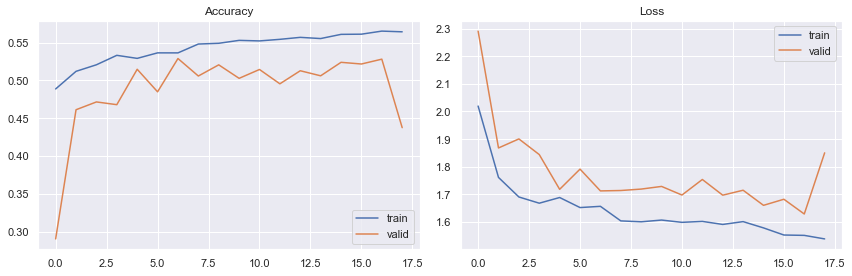

In [22]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show()

<b>4. Now, we'll test our model on a real example


In [23]:
test_true = np.argmax(Y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

2022-02-02 14:21:08.044010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


CNN Model Accuracy on test set: 0.5319


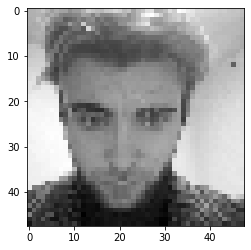

Predicted value: neutral


In [23]:
from skimage import io

emotions = ('angrer', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral')

img = image.load_img("./img.png", grayscale=True, target_size=(48, 48))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

# normalize
x /= 255

# make a prediction
pred = model.predict(x)
index = np.argmax(pred[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

# plotting
plt.gray()
plt.imshow(img)
plt.show()

print('Predicted value:', emotions[index])

<b>5. Conclusion


<del>По результатам обучения точность предсказания модели на валидационном датасете составляет 59 процентов - что в довольно неплохо.
Безусловно , точность предсказания  можно улучшить. Один из возможных способов - это увеличить размера датасета 
Так как датасет, который использовался для обучения - относительно небольшой ( 35887 примеров) модель склонна к переобучению 
( при больщом кол-ве итераций начинает запоминать примеры ).
Одна из возможных мер решения данной проблемы ( переобучения) - добавление в архитектуру  сети  dropout слой.
Что собственно и было сделано, но это незначительно улучшило точность предсказания ( примерно на 5 процентов)
Была сделана попытка увеличить/уменьшить размер минибатча (с 32) до 64 и 16 соответсвенно - результаты в обоих случаях оказались хуже.
Еще можно попробовать добавить регуляризацию L1 L2 и посмотреть в сторону изменения архитектуры сети.